# /!\ Data on CICLAD /!\

# Load modules
[#Load-ensemble-mean](#Load-ensemble-mean)  
[#Check-monthly-data](#Check-monthly-data)  
[#Annual-Climatology](#Annual-Climatology)  
[#Bias](#Bias)  
[#Annual-cycle-ensemble-mean](#Annual-cycle-ensemble-mean)  
[#Trends](#Trends)

In [1]:
# To reload external files automatically (ex: utils)
%load_ext autoreload
%autoreload 2

import xarray as xr
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle # For rectangles
import proplot as plot # New plot library (https://proplot.readthedocs.io/en/latest/)
from scipy import stats # For linregress (trends)
import xesmf as xe # For regridding (https://xesmf.readthedocs.io/en/latest/)

# import sys
# sys.path.insert(1, '../../../') # to include my util file in previous directory
import utils as u # my personal functions (in the file utils.py)
u.check_python_version()
u.check_virtual_memory()

3.8.2 | packaged by conda-forge | (default, Feb 28 2020, 17:15:22) 
[GCC 7.3.0]
Virtual memory usage - total: 252 GB / available: 179 GB / percent used: 28.8 %


# Load model data

In [2]:
# Define period
period = slice('1981','2014')

# Define zone
latlim=(10,50)
lonlim=(60,110)

# Model
institute = 'IPSL'
model = 'IPSL-CM6A-LR'
var = 'tas'
table = 'Amon'

var_label = 'Near-Surface Air Temperature [°C]'
var_label_trends = 'Near-Surface Air Temperature trends [°C/dec]'
var_label_bias = 'Near-Surface Air Temperature bias [°C]'

[#Load-ensemble-mean](#Load-ensemble-mean)

## Load first member

In [3]:
realization = 'r1i1p1f1'

# Load historical
da_historical = xr.open_mfdataset(
    '/bdd/CMIP6/CMIP/'+institute+'/'+model+'/historical/'+realization+'/'+table+'/'+var+'/gr/latest/*.nc', combine='by_coords'
).sel(time=period)[var]

## Create ensemble mean
See: http://xarray.pydata.org/en/stable/generated/xarray.open_mfdataset.html

### da_historical

In [4]:
realization = '*'
experiment = 'historical'

da_historical_ens = xr.open_mfdataset(
    '/bdd/CMIP6/CMIP/'+institute+'/'+model+'/'+experiment+'/'+realization+'/'+table+'/'+var+'/gr/latest/*.nc', 
    combine='nested', concat_dim='realization', parallel=True
).sel(time=period)[var]

da_historical_ens

<xarray.DataArray 'tas' (realization: 32, time: 408, lat: 143, lon: 144)>
dask.array<getitem, shape=(32, 408, 143, 144), dtype=float32, chunksize=(1, 408, 143, 144), chunktype=numpy.ndarray>
Coordinates:
    height   float64 2.0
  * time     (time) datetime64[ns] 1981-01-16T12:00:00 ... 2014-12-16T12:00:00
  * lon      (lon) float32 0.0 2.5 5.0 7.5 10.0 ... 350.0 352.5 355.0 357.5
  * lat      (lat) float32 -90.0 -88.73239 -87.46479 ... 87.46479 88.73239 90.0
Dimensions without coordinates: realization
Attributes:
    online_operation:    average
    cell_methods:        area: time: mean
    interval_operation:  900 s
    interval_write:      1 month
    standard_name:       air_temperature
    description:         Near-Surface Air Temperature
    long_name:           Near-Surface Air Temperature
    history:             none
    units:               K
    cell_measures:       area: areacella

In [5]:
ens = da_historical_ens.mean('realization', keep_attrs=True)
ens.attrs['realization'] = da_historical_ens.realization.size
ens

<xarray.DataArray 'tas' (time: 408, lat: 143, lon: 144)>
dask.array<mean_agg-aggregate, shape=(408, 143, 144), dtype=float32, chunksize=(408, 143, 144), chunktype=numpy.ndarray>
Coordinates:
    height   float64 2.0
  * time     (time) datetime64[ns] 1981-01-16T12:00:00 ... 2014-12-16T12:00:00
  * lon      (lon) float32 0.0 2.5 5.0 7.5 10.0 ... 350.0 352.5 355.0 357.5
  * lat      (lat) float32 -90.0 -88.73239 -87.46479 ... 87.46479 88.73239 90.0
Attributes:
    online_operation:    average
    cell_methods:        area: time: mean
    interval_operation:  900 s
    interval_write:      1 month
    standard_name:       air_temperature
    description:         Near-Surface Air Temperature
    long_name:           Near-Surface Air Temperature
    history:             none
    units:               K
    cell_measures:       area: areacella
    realization:         32

In [6]:
root_path='/data/mlalande/bdd/CMIP6/CMIP/'+institute+'/'+model+'/'+experiment+'/ens/'+table+'/'+var+'/gr/latest'
root_path
# mkdir -p root_path

'/data/mlalande/bdd/CMIP6/CMIP/IPSL/IPSL-CM6A-LR/historical/ens/Amon/tas/gr/latest'

In [7]:
ens.to_netcdf(root_path+'/'+var+'_'+table+'_'+model+'_'+experiment+'_ens_gr_198101-201412.nc')

# Load ensemble mean

In [8]:
realization = 'ens'
# Load historical ens
experiment='historical'
da_historical = xr.open_dataarray(
    '/data/mlalande/bdd/CMIP6/CMIP/'+institute+'/'+model+'/'+experiment+'/'+realization+'/'+table+'/'+var+'/gr/latest/'+\
    var+'_'+table+'_'+model+'_'+experiment+'_'+realization+'_gr_198101-201412.nc'
) - 273.15

# Load obs (cru_ts4.00)

In [9]:
obs_longname = 'CRU TS v. 4.00'
obs_name = 'CRU'

obs = xr.open_dataset('/bdd/cru/cru_ts_4.00/data/tmp/cru_ts4.00.1901.2015.tmp.dat.nc').sel(time=period).tmp
obs

<xarray.DataArray 'tmp' (time: 408, lat: 360, lon: 720)>
[105753600 values with dtype=float32]
Coordinates:
  * lon      (lon) float32 -179.75 -179.25 -178.75 ... 178.75 179.25 179.75
  * lat      (lat) float32 -89.75 -89.25 -88.75 -88.25 ... 88.75 89.25 89.75
  * time     (time) datetime64[ns] 1981-01-16 1981-02-15 ... 2014-12-16
Attributes:
    long_name:                   near-surface temperature
    units:                       degrees Celsius
    correlation_decay_distance:  1200.0

## Regrid using xESMF (https://xesmf.readthedocs.io/en/latest/) 

In [10]:
regridder_obs = xe.Regridder(obs, da_historical, 'bilinear', periodic=True, reuse_weights=True)
obs_regrid = regridder_obs(obs)

Reuse existing file: bilinear_360x720_143x144_peri.nc


### Problem with NaN's if not global dataset
https://github.com/JiaweiZhuang/xESMF/issues/15

In [11]:
# # For adding NaN values outside of the grid, otherwise it puts 0 (see issue just up #15)
# import scipy
# def add_matrix_NaNs(regridder):
#     X = regridder.weights
#     M = scipy.sparse.csr_matrix(X)
#     num_nonzeros = np.diff(M.indptr)
#     M[num_nonzeros == 0, 0] = np.NaN
#     regridder.weights = scipy.sparse.coo_matrix(M)
#     return regridder

# # Make the regrider
# regridder_obs = xe.Regridder(obs, da_historical, 'bilinear', periodic=False, reuse_weights=True)
# regridder_obs = add_matrix_NaNs(regridder_obs)
# print(regridder_obs)

# # Regrid the data
# obs_regrid = regridder_obs(obs)

# Check monthly data

In [12]:
obs_mon = obs.sel(lat=slice(latlim[0],latlim[1]), lon=slice(lonlim[0],lonlim[1])
                 ).groupby('time.month').mean('time')

/data/mlalande/miniconda3/envs/work/lib/python3.8/site-packages/xarray/core/nanops.py:142: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)


### Facet plots

http://xarray.pydata.org/en/stable/plotting.html#id4

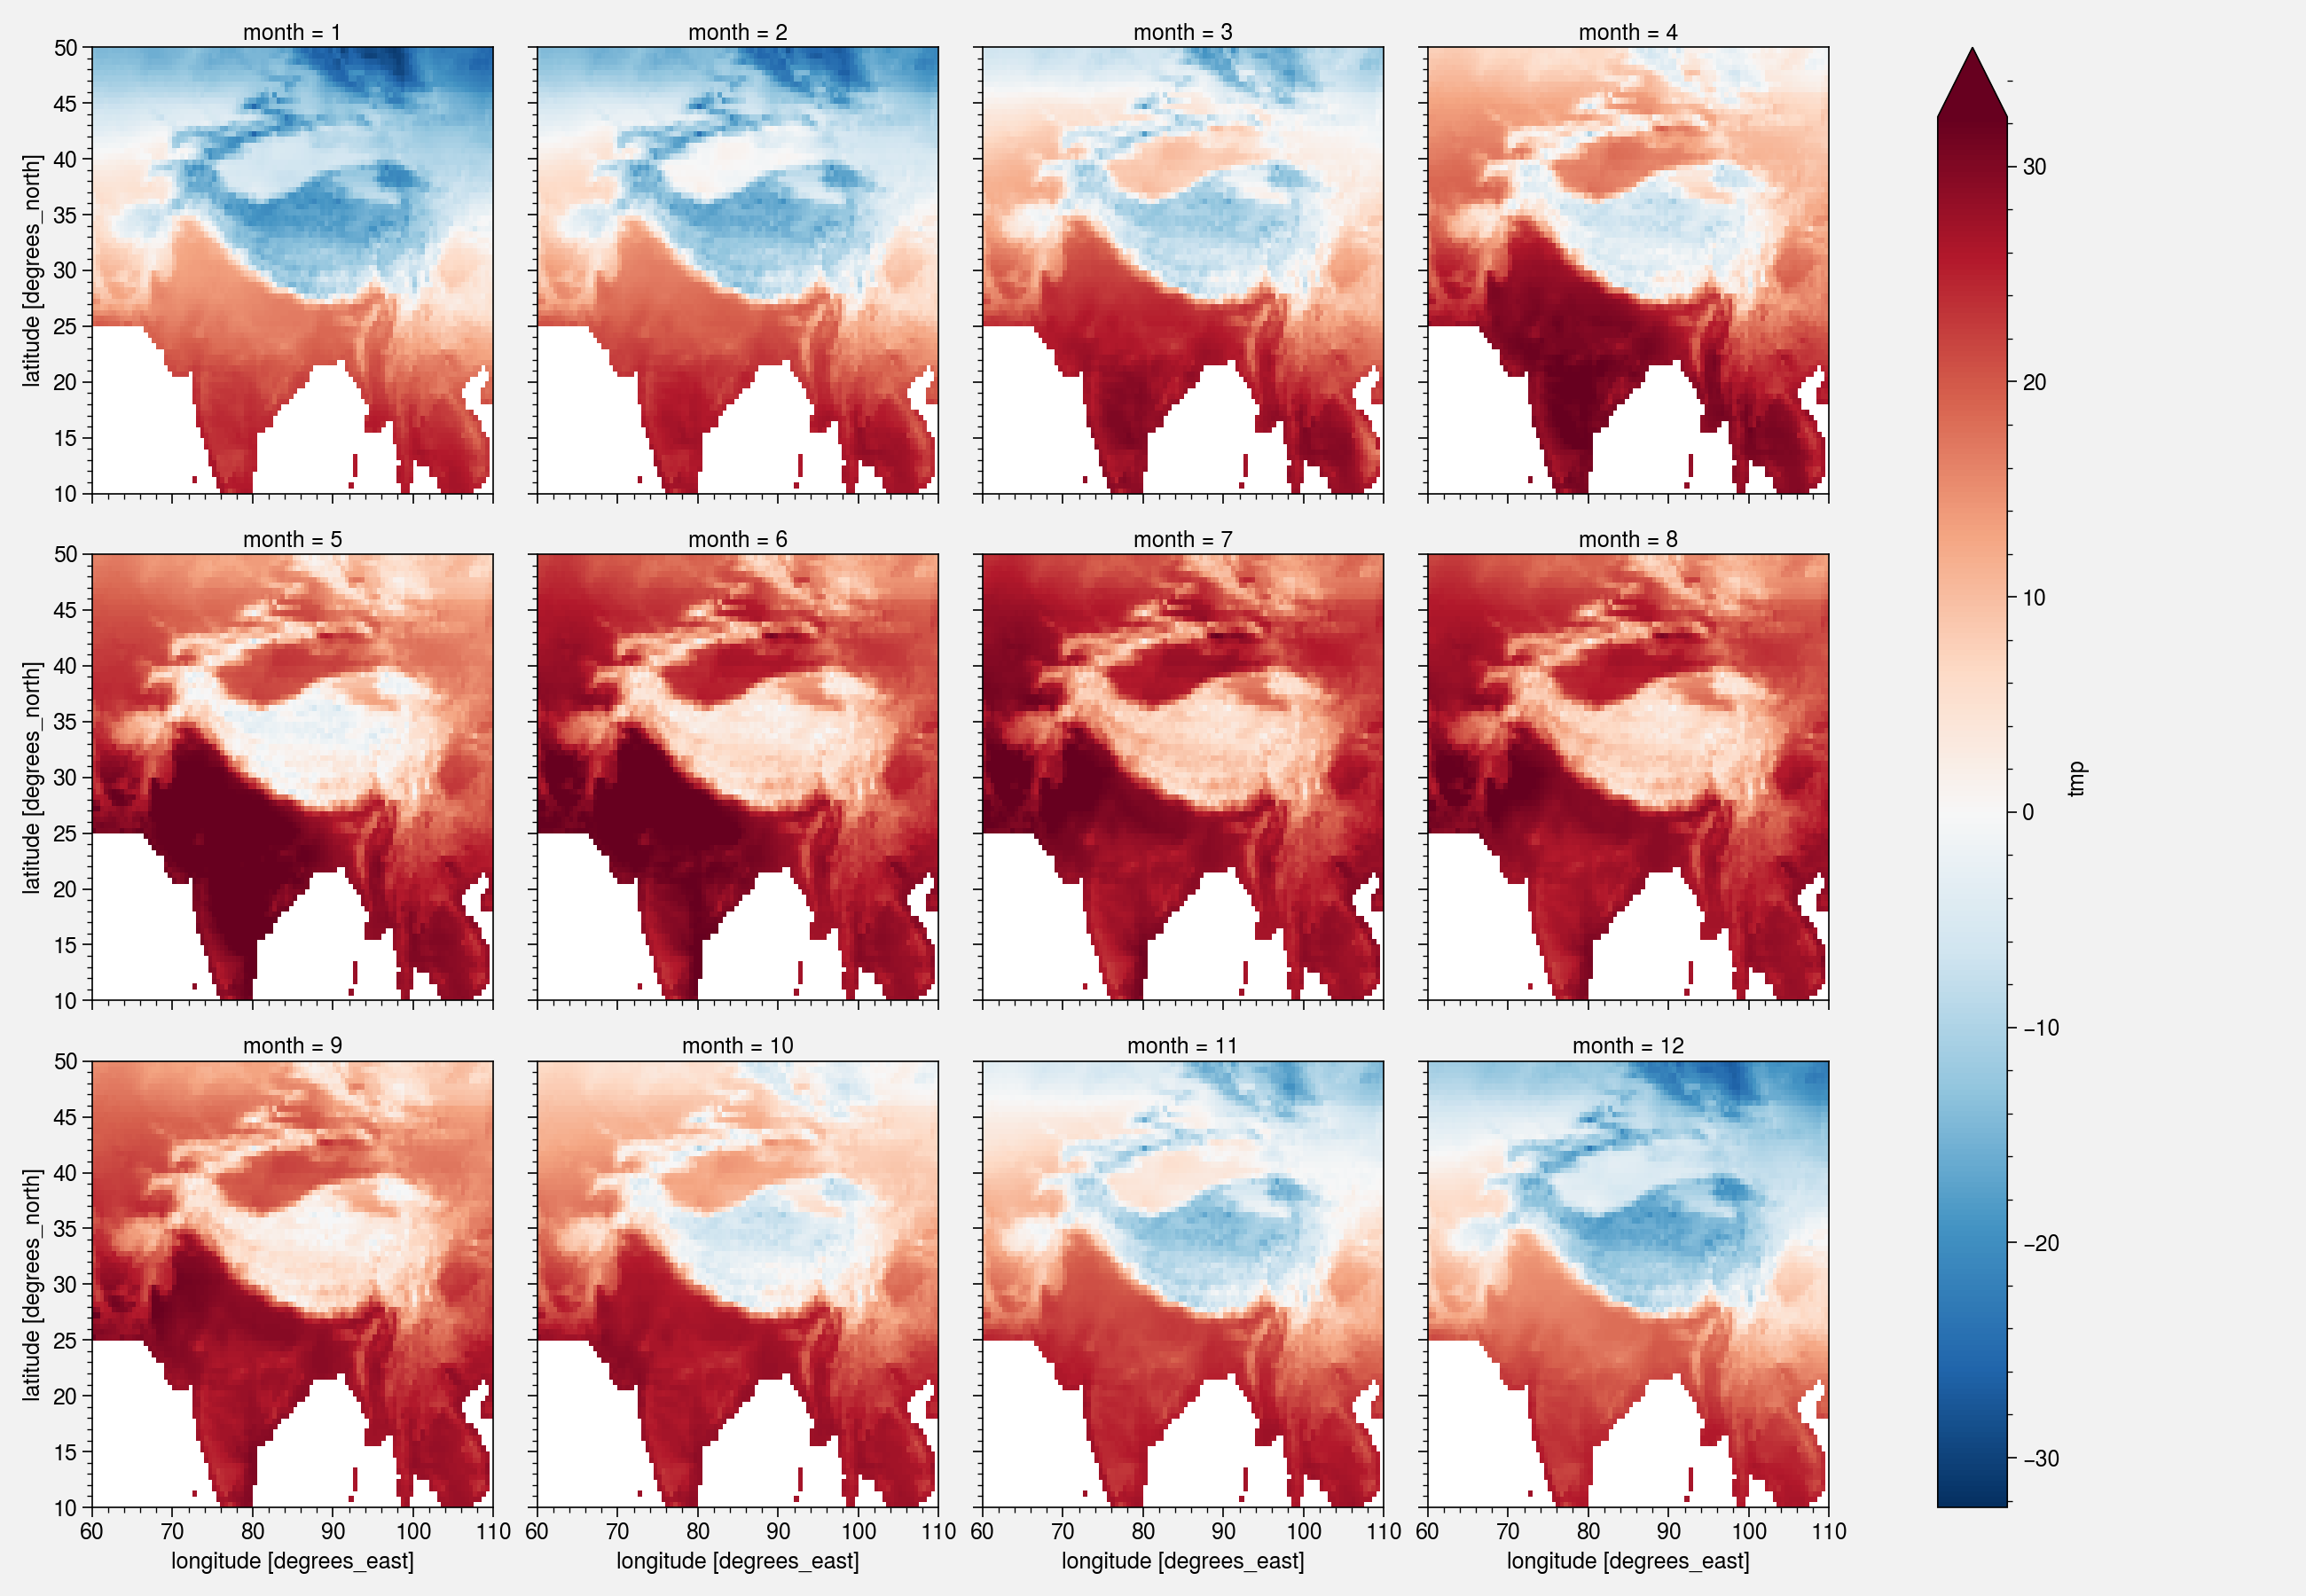

In [13]:
obs_mon.plot(col='month', col_wrap=4, robust=True)

### Proplot example
https://proplot.readthedocs.io/en/latest/projections.html

Proplot automatically save plots with a good dpi (https://proplot.readthedocs.io/en/latest/basics.html?highlight=journals#Creating-figures)

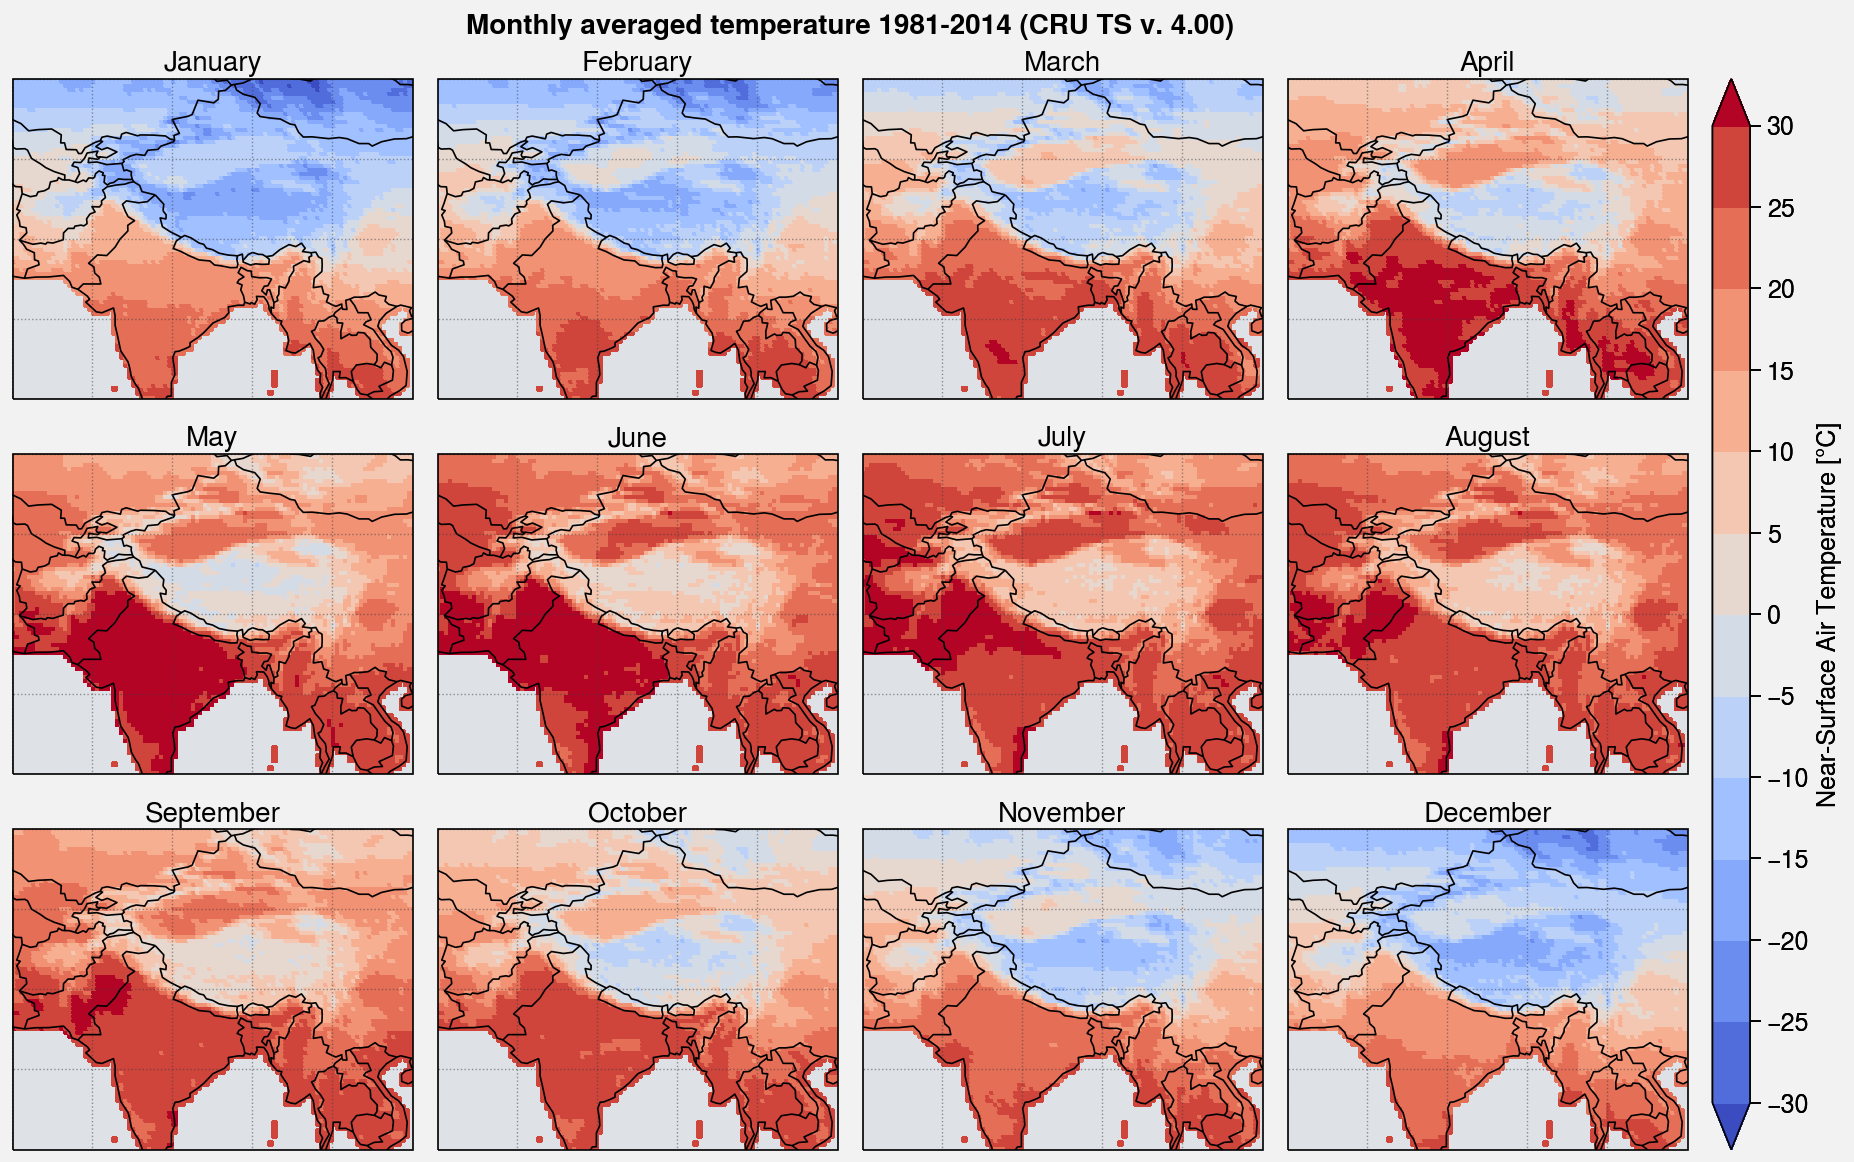

In [14]:
import calendar

cmap='CoolWarm'
levels=plot.arange(-30,30,5)

f, axs = plot.subplots(proj='cyl', ncols=4, nrows=3, share=3, axwidth=2)

for i, ax in enumerate(axs):
    m = ax.pcolormesh(obs_mon.isel(month=i), cmap=cmap, levels=levels, extend='both')
    ax.format(title=calendar.month_name[i+1])
    
f.colorbar(m, label=var_label)

axs.format(
    geogridlinewidth=0.5, geogridcolor='gray8', geogridalpha=0.5, labels=False, 
    coast=True, ocean=True, oceancolor='gray3', borders=True,
    suptitle='Monthly averaged temperature 1981-2014 ('+obs_longname+')',
    lonlines=10, latlines=10, abc=False, latlim=latlim, lonlim=lonlim
)

# f.save('img/'+var+'/mon_'+var+'_'+obs_name+'_1981-2014.jpg')
# f.save('img/'+var+'/mon_'+var+'_'+obs_name+'_1981-2014.png')
# f.save('img/'+var+'/mon_'+var+'_'+obs_name+'_1981-2014.pdf')

## Annual Climatology
I use here a personal function `clim()` (in `utils.py`) that take into account the number of days in a month, see: https://github.com/mickaellalande/PhD/blob/master/examples/clim_example.ipynb for more details about the function that can be found in the file utils.py.

For seasonnal studies you can check `custom_season_clim()` (in `utils.py`): https://github.com/mickaellalande/PhD/blob/master/examples/custom_season_clim_example.ipynb

Xarray uses *lazy load*, so if you want to load into memory some computation you can use `.load()` or `.persist()` to save time when used later. See http://xarray.pydata.org/en/stable/io.html#reading-and-writing-files for more details

In [15]:
da_historical_clim = u.clim(da_historical.sel(lat=slice(latlim[0],latlim[1]), lon=slice(lonlim[0],lonlim[1]))).load()
obs_regrid_clim = u.clim(obs_regrid.sel(lat=slice(latlim[0],latlim[1]), lon=slice(lonlim[0],lonlim[1]))).load()
obs_clim = u.clim(obs.sel(lat=slice(latlim[0],latlim[1]), lon=slice(lonlim[0],lonlim[1]))).load()

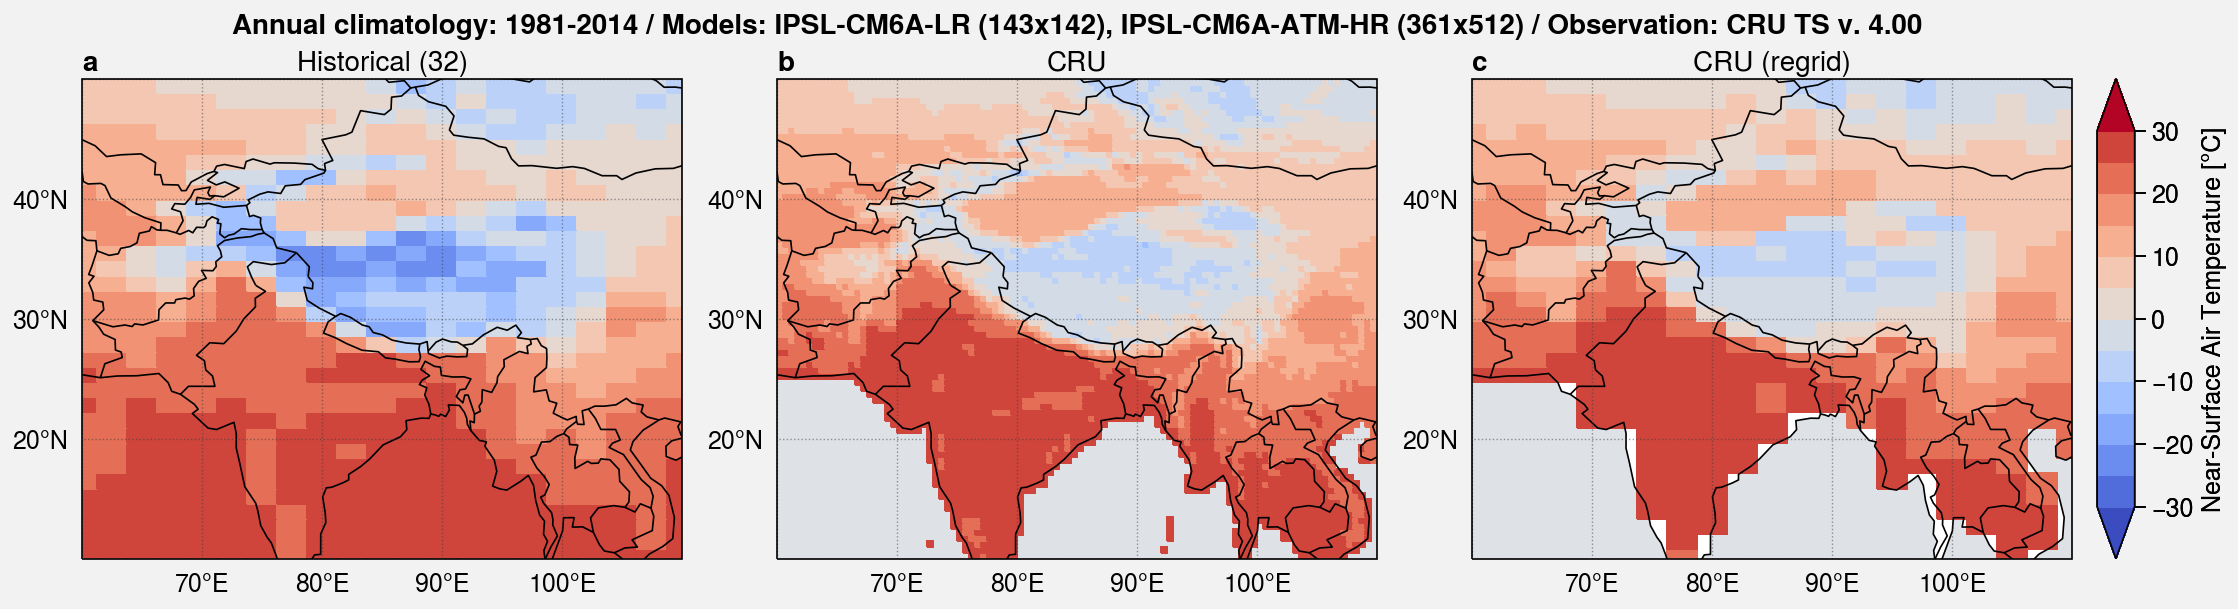

In [16]:
f, axs = plot.subplots(nrows=1, ncols=3, proj='cyl', axwidth=3)

extend='both'
  
axs[0].pcolormesh(da_historical_clim, cmap=cmap, levels=levels, extend=extend)
axs[0].format(title='Historical (32)') 

axs[1].pcolormesh(obs_clim, cmap=cmap, levels=levels, extend=extend)
axs[1].format(title=obs_name) 

axs[2].pcolormesh(obs_regrid_clim, cmap=cmap, levels=levels, extend=extend)
axs[2].format(title=obs_name+' (regrid)')

f.colorbar(m, label=var_label)

axs.format(
    geogridlinewidth=0.5, geogridcolor='gray8', geogridalpha=0.5, labels=True, 
    coast=True, ocean=True, oceancolor='gray3', borders=True,
    suptitle="Annual climatology: 1981-2014 / Models: IPSL-CM6A-LR (143x142), IPSL-CM6A-ATM-HR (361x512) / Observation: "+obs_longname,
    lonlines=10, latlines=10, abc=True, latlim=latlim, lonlim=lonlim
)

# f.save('img/'+var+'/annual_clim_'+var+'_IPSL_CMIP6.png')
# f.save('img/'+var+'/annual_clim_'+var+'_IPSL_CMIP6.pdf')

# Bias

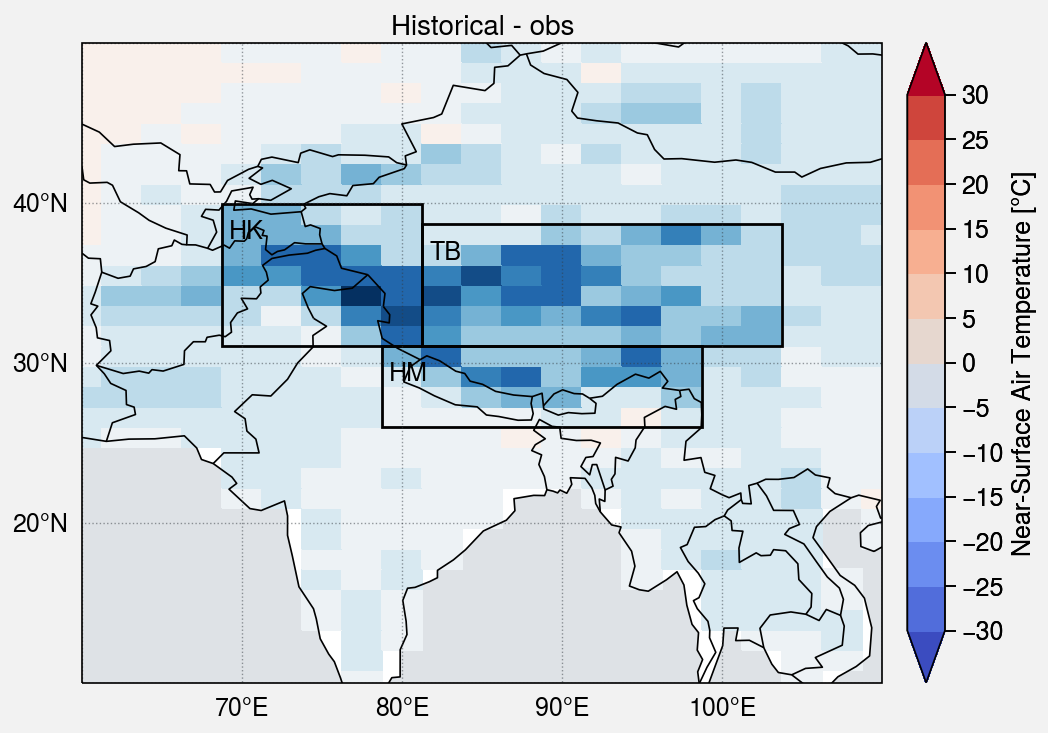

In [17]:
f, axs = plot.subplots(proj='cyl', ncols=1, nrows=1, axwidth=4)

axs[0].pcolormesh(da_historical_clim - obs_regrid_clim, cmap='RdBu_r', levels=plot.arange(-20,20,2))
axs[0].format(title='Historical - obs')

f.colorbar(m, label=var_label)

# Add boxes
for ax in axs:
    u.plot_zones_IPSL_CM6A_LR(ax)

axs.format(
    geogridlinewidth=0.5, geogridcolor='gray8', geogridalpha=0.5, labels=True, 
    coast=True, ocean=True, oceancolor='gray3', borders=True,
    lonlines=10, latlines=10, abc=False, latlim=latlim, lonlim=lonlim
)

# f.save('img/'+var+'/'+var+'_IPSL_CMIP6_bias.png')
# f.save('img/'+var+'/'+var+'_IPSL_CMIP6_bias.pdf')

# Annual cycle ensemble mean

In [18]:
lonlim_HK, latlim_HK, lonlim_HM, latlim_HM, lonlim_TB, latlim_TB = u.get_zones_IPSL_CM6A_LR()

titles = ['HK', 'HM', 'TB']
zone_slices = [
    [slice(lonlim_HK[0],lonlim_HK[1]), slice(latlim_HK[0],latlim_HK[1])],
    [slice(lonlim_HM[0],lonlim_HM[1]), slice(latlim_HM[0],latlim_HM[1])],
    [slice(lonlim_TB[0],lonlim_TB[1]), slice(latlim_TB[0],latlim_TB[1])]
]

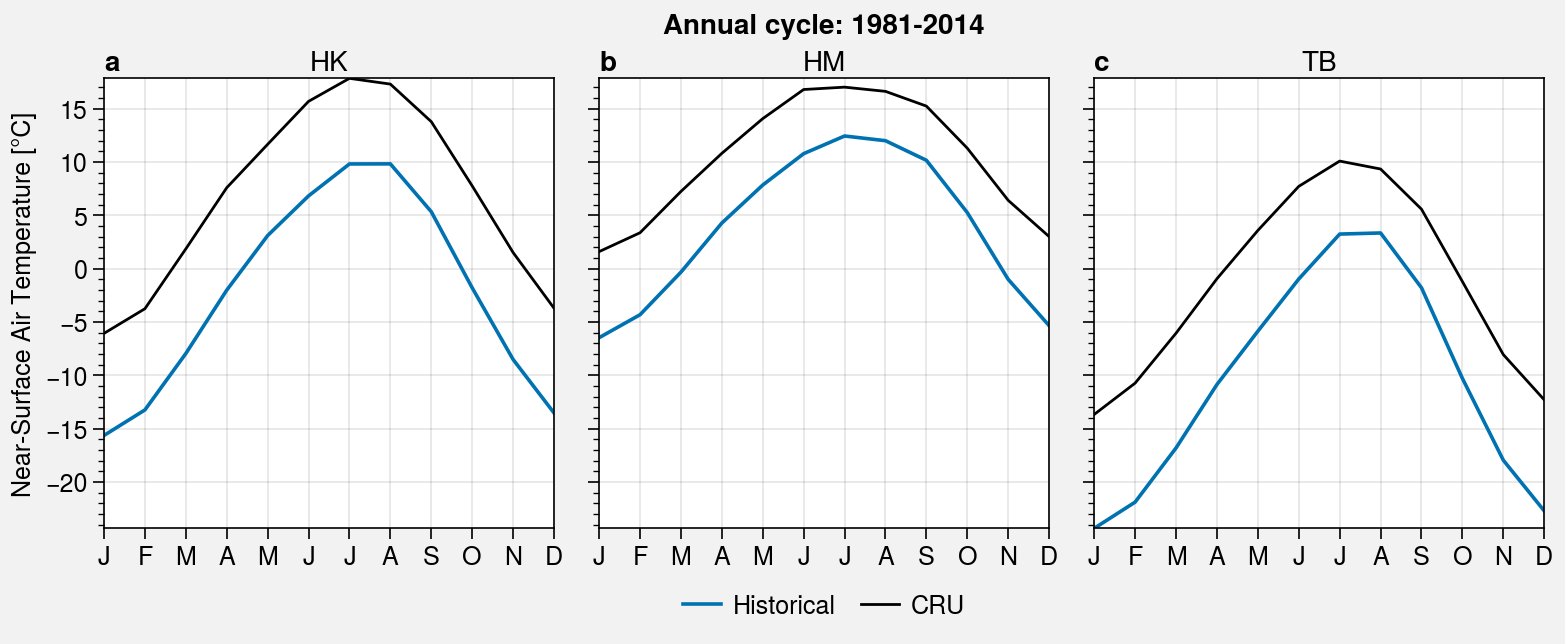

In [19]:
f, axs = plot.subplots(ncols=3, nrows=1)

for i, ax in enumerate(axs):
    
    # Compute annual cycles on the zone
    ac_historical = u.annual_cycle(u.spatial_average(
        da_historical.sel(lon=zone_slices[i][0], lat=zone_slices[i][1])
    )).load()

    ac_obs_regrid = u.annual_cycle(u.spatial_average(
        obs_regrid.sel(lon=zone_slices[i][0], lat=zone_slices[i][1])
    )).load()
    
    h1 = ac_historical.plot(ax=ax, label='Historical')
    h2 = ac_obs_regrid.plot(ax=ax, label=obs_name, color='black', linewidth=1)
    
    ax.format(title=titles[i])
    hs = [h1, h2]

axs.format(
    xlocator='index', xformatter=['J','F','M','A','M','J','J','A','S','O','N','D'], xtickminor=False,
    xlabel='', ylabel=var_label, suptitle='Annual cycle: 1981-2014', abc=True
)
    
f.legend(hs, loc='b', ncols=2, order='F', center=False, frame=False)

# f.save('img/'+var+'/ac_zones_'+var+'.png')
# f.save('img/'+var+'/ac_zones_'+var+'.pdf')

# Trends   

Linregress: https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.linregress.html  
Issues linregress: https://github.com/scipy/scipy/issues/7074  
How to parallelize/vectorize: https://stackoverflow.com/questions/52094320/with-xarray-how-to-parallelize-1d-operations-on-a-multidimensional-dataset
Xarray / Dask example: http://martin-jung.github.io/post/2018-xarrayregression/

Use again a personal function `year_mean()` (from `utils.py`): https://github.com/mickaellalande/PhD/blob/master/examples/year_mean_example.ipynb

In [20]:
# You can also use a loop on lon/lat but way longer!
def corr(x, y, dim):
    return xr.apply_ufunc(
        stats.linregress, x, y,
        input_core_dims=[[dim], [dim]],
        output_core_dims=[[], [], [], [], []],
        vectorize=True
    )

In [21]:
# Add directly the results of linregress to the dataarray
# Compute year mean first
ym_obs = u.year_mean(obs.sel(lat=slice(latlim[0],latlim[1]), lon=slice(lonlim[0],lonlim[1])))
ym_obs.load()
for arr_name, arr in zip(['slope', 'intercept', 'rvalue', 'pvalue', 'stderr'], corr(ym_obs.year, ym_obs, 'year')):
    ym_obs[arr_name] = arr

In [22]:
ym_obs.coords

Coordinates:
  * lon        (lon) float32 60.25 60.75 61.25 61.75 ... 108.75 109.25 109.75
  * lat        (lat) float32 10.25 10.75 11.25 11.75 ... 48.25 48.75 49.25 49.75
  * year       (year) int64 1981 1982 1983 1984 1985 ... 2011 2012 2013 2014
    slope      (lat, lon) float64 nan nan nan nan ... 0.01993 0.02016 0.01981
    intercept  (lat, lon) float64 nan nan nan nan ... -42.89 -43.22 -43.33
    rvalue     (lat, lon) float64 nan nan nan nan ... 0.2614 0.2661 0.2608
    pvalue     (lat, lon) float64 nan nan nan nan ... 0.1353 0.1282 0.1363
    stderr     (lat, lon) float64 nan nan nan nan ... 0.01301 0.01291 0.01296

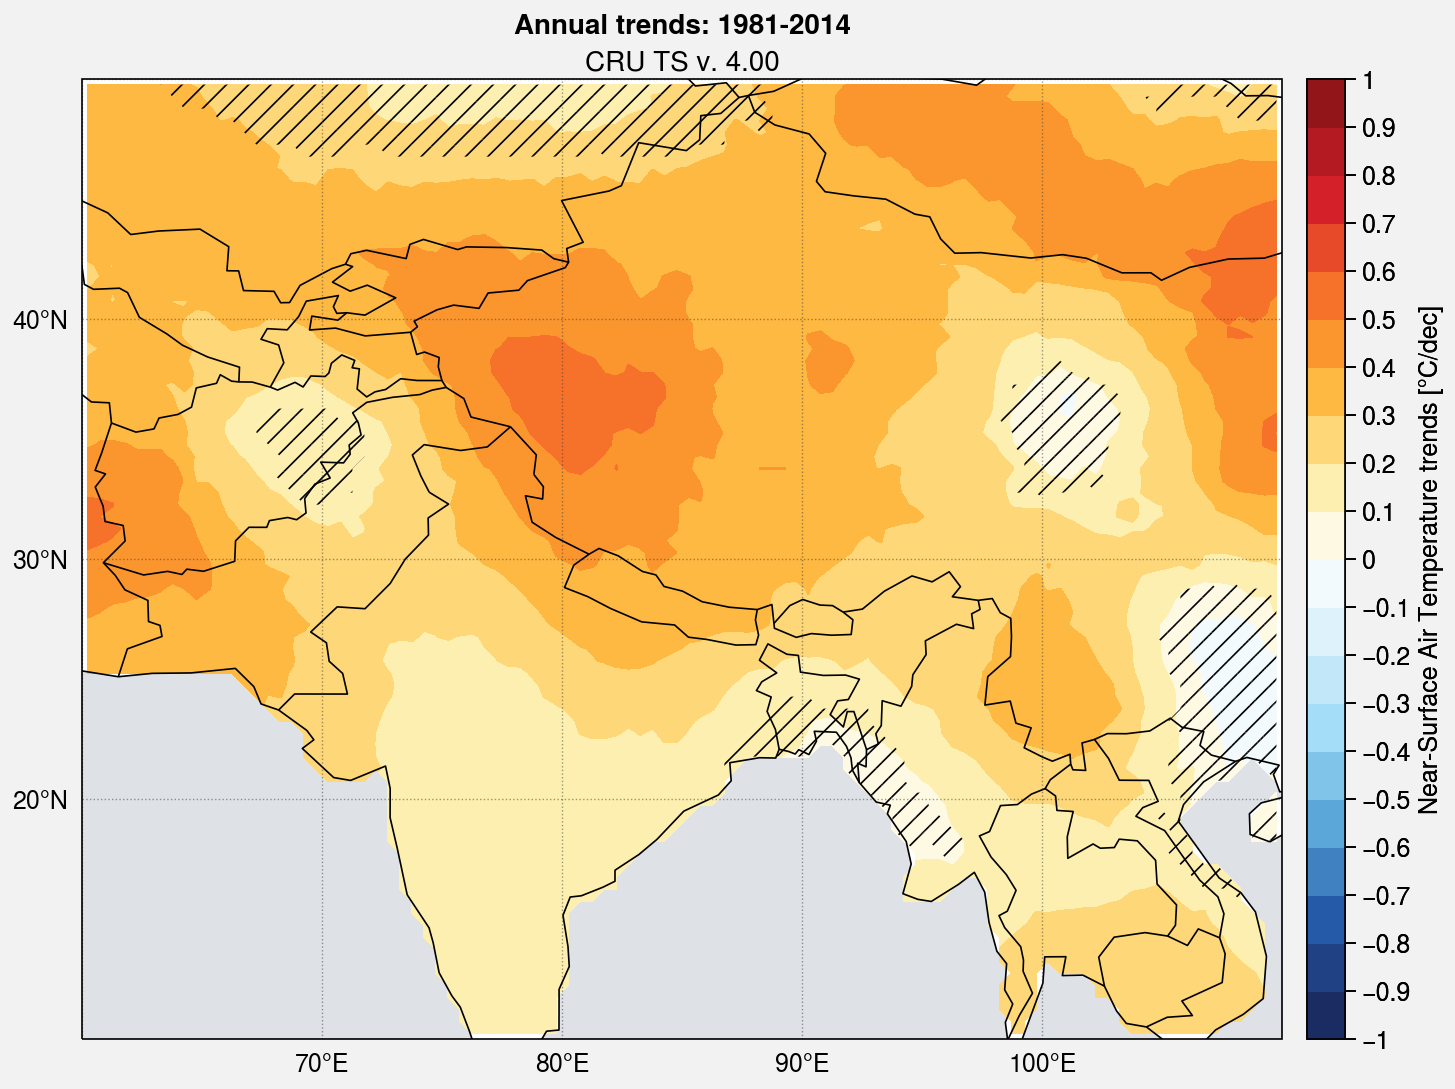

In [23]:
f, axs = plot.subplots(proj='cyl', axwidth=6)

cmap='ColdHot'
levels=plot.arange(-1,1,0.1)
extend='neither'

m = axs[0].contourf(ym_obs.slope*10, cmap=cmap, levels=levels, extend=extend)
axs[0].contourf(ym_obs.pvalue.where(ym_obs.pvalue>0.05), hatches=['///'], alpha=0)
axs[0].format(title=obs_longname)

f.colorbar(m, label=var_label_trends, formatter=('simple', 3))

# Format
axs.format(
    geogridlinewidth=0.5, geogridcolor='gray8', geogridalpha=0.5, labels=True, 
    coast=True, ocean=True, oceancolor='gray3', borders=True,
    suptitle="Annual trends: 1981-2014",
    lonlines=10, latlines=10, abc=False, latlim=latlim, lonlim=lonlim
)

# f.save('img/'+var+'/annual_trends_'+var+'_IPSL_CMIP6.png')
# f.save('img/'+var+'/annual_trends_'+var+'_IPSL_CMIP6.pdf')